In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(monocle3, quietly = T)
    library(SeuratWrappers, quietly = T)
    
    library(ggplot2, quietly = T)
    library(cowplot, quietly = T)
})

In [2]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
}

Associated tutorials:

1) https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/
2) http://htmlpreview.github.io/?https://github.com/satijalab/seurat-wrappers/blob/master/docs/monocle3.html
3) https://stuartlab.org/signac/articles/monocle.html

In [3]:
# Load and format T cell data to get just the CD8s

In [4]:
abc.tcells<-readRDS(paste0(data_path, 'processed/abc_tcells.RDS'))
Idents(abc.tcells)<-'Cell.Type.Level2'

Subset to just the CD8+ T cells

In [5]:
abc.cd8s.all<-abc.tcells[, unname(sapply(as.character(abc.tcells$Cell.Type.Level2), function(x) startsWith(x, 'CD8+')))]
abc.cd8s.so<-Seurat::SplitObject(abc.cd8s.all, split.by = 'orig.ident')

Do the trajectory analysis:

In [6]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, cell.type="CD8+ TN"){
  cell_ids <- which(colData(cds)[, "Cell.Type.Level2"] == cell.type)
  
  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}

calculate trajectory on each condition separately

In [7]:
abc.cd8s <- lapply(X = abc.cd8s.so, FUN = function(x){
    x<-SeuratWrappers::as.cell_data_set(x)
    x<-monocle3::cluster_cells(cds = x)
    x<-monocle3::learn_graph(cds = x)#, use_partition = F) 

#     cd8_tn<-rownames(colData(x)[x$Cell.Type.Level2 == 'CD8+ TN', ])
#     x<-monocle3::order_cells(x, root_cells = cd8_tn) # get trajectory with CD8 TN as root
    x <- order_cells(x, root_pr_nodes=get_earliest_principal_node(x))
})

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Gray circles are leaves and blue circles are branch points:

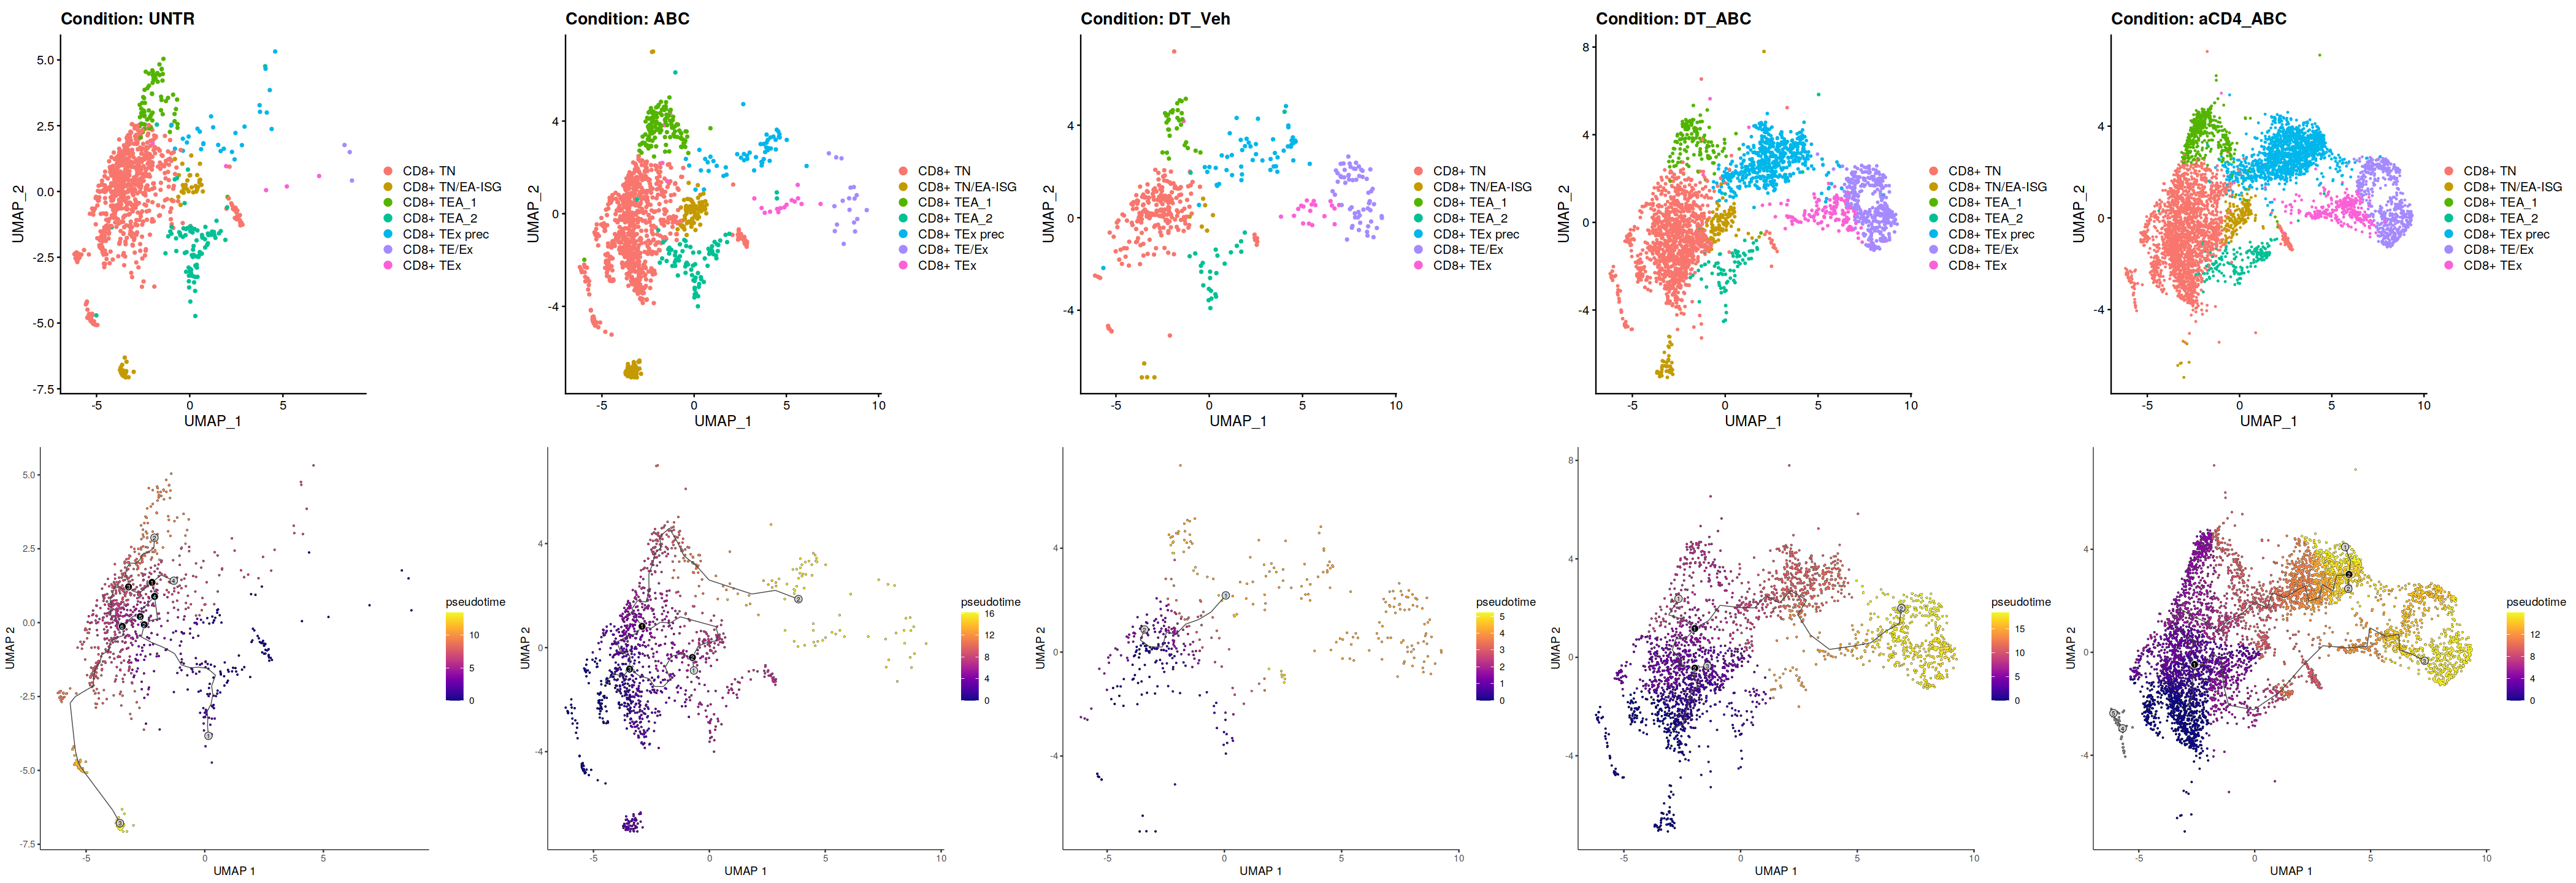

In [10]:
h_ = 12
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

g1<-cowplot::plot_grid(plotlist=traj.plots, ncol = length(traj.plots))

for (ext in c('.svg', '.png', '.pdf')){
    fn<-paste0(data_path, 'figures/', 'cd8_trajectory_separate', ext)
    ggsave(fn, g1, height = h_, width = w_)}

g1